In [1]:
import main_ver03 as main03
import os
import pickle
from PIL import Image
import urllib
import pandas as pd
import numpy as np
import seaborn as sns
import math
import warnings
from mplsoccer import Pitch, add_image, VerticalPitch, FontManager
import matplotlib as mpl
import matplotlib.patheffects as path_effects
from matplotlib.font_manager import FontProperties
from adjustText import adjust_text
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from highlight_text import HighlightText, fig_text, ax_text
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

warnings.filterwarnings('ignore')

In [2]:
team_name = "barcelona"
team_id = 65
season = input(str("season:"))
week = input(str('period:'))

season: 2223
period: 1


In [3]:
homeColor = "#B00202"
cmapA = LinearSegmentedColormap.from_list("my_cmap", ["#171717", homeColor], N=100)
# Pink -> Red
# cmapA = LinearSegmentedColormap.from_list("my_cmap", ["#FABEC0", "#F85C70", "#F37970" ,"#E43D40"], N=4)
# Handpainted Sky
# cmapA = LinearSegmentedColormap.from_list("my_cmap", ["#5D59AF", "#A072BE", "#BE81B6" ,"#5D59AF"], N=4)
# Lava Sky
# cmapA = LinearSegmentedColormap.from_list("my_cmap", ["#432F70", "#713770" , "#B34270", "#E95670"], N=4)
# Blue -> Red
cmapA = LinearSegmentedColormap.from_list("my_cmap", ["#75E6DA", "#189AB4", "#FF033E", "#E1002A"], N=4)
# Green
# cmapA = LinearSegmentedColormap.from_list("my_cmap", ["#97ED6E", "#5DE31D", "#2B690D", "#1A4008"], N=4)
# Blue
# cmapA = LinearSegmentedColormap.from_list("my_cmap", ["#35A4FB", "#0476D0", "#024376", "#012949"])

font_prop = FontProperties(fname="/usr/share/fonts/Nippo-Regular.ttf")

In [4]:
class PassNetwork:

    def __init__(self, ax, team_name, season, week, venue):
        self.ax = ax
        self.team_name = team_name
        self.season = season
        self.week = week  
        self.venue = venue
        self.team_id = None
        self.team_age = None
        self.opponent_name = None
        self.teamFormation = None
        self.venue_name = None
        self.league = None
        self.score = None
        self.referee = None
        self.attendance = None
        self.team_players_dict = {}

        self.custom_x = 'x_median'
        self.custom_end_x = 'x_median_end'
        self.custom_y = 'y_median'
        self.custom_end_y = 'y_median_end'
        
        self.MULTI_MARKER_SIZE = 3.5
        self.MULTI_LINE_WIDTH = .35

        self.SHRINK_VAL_A = 12 #Units by which the arrow is shortened from the end_points
        self.SHRINK_VAL_B = 12 #Units by which the arrow is shortened from the start_points
        self.ARROW_SHIFT = 2 #Units by which the arrow moves from its original position
        
        self.MAX_LINE_WIDTH = 10
        self.MAX_MARKER_SIZE = 500
        self.COLOR_CODE = '#87CEEB'
        self.MIN_TRANSPARENCY = 0.3
        self.vertical_passer = None
        self.vertical_pass = None

    def add_xT(self, df):
        #Bin Data for xT
        xT = pd.read_csv("/work/assets/xT_Grid.csv")
        xT = np.array(xT)
        xT_rows, xT_cols = xT.shape
        
        # We use a pandas method called .cut --> https://pandas.pydata.org/docs/reference/api/pandas.cut.html
        # We say labels=False because we want the integer locator of the bin
        df['x_bin'] = pd.cut(df['x'], bins=xT_cols, labels=False)
        df['y_bin'] = pd.cut(df['y'], bins=xT_rows, labels=False)
        df['endX_bin'] = pd.cut(df['endX'], bins=xT_cols, labels=False)
        df['endY_bin'] = pd.cut(df['endY'], bins=xT_rows, labels=False)

        # Return Bin Values for xT
        # We use a lambda function to assign the values from the bins to the x and y values with numpy array slicing
        # it is going through each row and assigning the values based on where those numbers are in the numpy array
        # kind of an advanced topic, so be sure to familiarize yourself with slicing and indexing
        # its basically doing this: xT[4][5] where 4 is the fourth list and 5 is the fifth item in that list
        df['start_zone_value'] = df[['x_bin', 'y_bin']].apply(lambda x: xT[x[1]][x[0]], axis=1)
        df['end_zone_value'] = df[['endX_bin', 'endY_bin']].apply(lambda x: xT[x[1]][x[0]], axis=1)

        # now we find the difference between the start and end to get the xT value
        df['xT'] = df['end_zone_value'] - df['start_zone_value']
        
        return df
    
    def count_vertical(self, df):
        df = df[(df["teamId"]==self.team_id)&(df["playerId"]!=80774)&(df["playerId"]!=79554)].reset_index()
        df = df[df["type"]=="Pass"].reset_index(drop=True)
        df = df[df['outcomeType']=='Successful'].reset_index(drop=True)
        
        df['beginning'] = np.sqrt(np.square(120-df['x']) + np.square(40-df['y']))
        df['end'] = np.sqrt(np.square(120-df['endX']) + np.square(40-df['endY']))
#         df['progressive'] = [(df.loc[x,'end']) / (df.loc[x,'beginning']) < .75 for x in range(len(df.beginning))]
        df['progressive'] = [(df.loc[x,'end']) / (df.loc[x,'beginning']) < .75 for x in range(len(df.beginning))]
        vertical = df[df['progressive']==True].reset_index()
        vertical = vertical.groupby(by=["playerName"])["id"].count().reset_index()
        vertical = vertical.sort_values(by=["id"], ascending=False).reset_index()
        self.vertical_passer = vertical.loc[0, "playerName"]
        self.vertical_pass = vertical.loc[0, "id"]
        
    def make_data(self, peri=None):
        
        with open(file=f"/work/assets/whoscored/{self.team_name}/match/{self.season}/matchData/#{self.week}.json", mode="rb") as file:
            match_data = pickle.load(file)

        match_id = match_data['matchId']
        self.team_id = match_data[self.venue]['teamId']
        self.teamFormation = match_data[self.venue]['formations'][0]['formationName']
        self.venue_name = match_data["venueName"]
        self.league = match_data["league"]
        self.score = match_data["score"]
        try:
            self.referee = match_data["referee"]["name"]
        except KeyError as e:
            self.referee = "unknown"
            print(e)
        self.attendance = match_data["attendance"]

        matches_df = main03.createMatchesDF(match_data)
        self.team_age = matches_df[self.venue][match_id]['averageAge']
        
        if self.venue == "home":
            self.opponent_name = matches_df["away"][match_id]['name']
        elif self.venue == "away":
            self.opponent_name = matches_df["home"][match_id]['name']
            

        events_df = main03.createEventsDF(match_data)  

        events_df = main03.addEpvToDataFrame(events_df)

        events_df = events_df.dropna(subset=["endX"])
        events_df["playerId"] = events_df["playerId"].astype(int)
        
        events_df = self.add_xT(events_df)

        for player in matches_df[self.venue][match_id]['players']:
            self.team_players_dict[player['playerId']] = player['name']
            
        if peri == 0:
            events_df = events_df[(events_df["period"]=="FirstHalf")]
        elif peri == 1:
            events_df = events_df[(events_df["period"]=="SecondHalf")]
            
        events_df["x"] = events_df["x"]*1.2
        events_df["endX"] = events_df["endX"]*1.2
        events_df["y"] = 80-(events_df["y"]*.8)
        events_df["endY"] = 80-(events_df["endY"]*.8)
            
        self.count_vertical(events_df)
        substitution_on = events_df[events_df["type"]=="SubstitutionOn"]

        match_events_df = events_df.reset_index(drop=True)

        passes_df = match_events_df[match_events_df["type"]=="Pass"].reset_index(drop=True)

        passes_df = passes_df[passes_df['teamId']==self.team_id].reset_index().drop('index', axis=1)
        passes_df = passes_df[passes_df['outcomeType']=='Successful'].reset_index(drop=True)

        passes_df['playerName'] = [self.team_players_dict[i] for i in list(passes_df['playerId'])]
        passes_df['passRecipientId'] = passes_df['playerId'].shift(-1)
        passes_df['passRecipientName'] = passes_df['playerName'].shift(-1)
        passes_df.dropna(subset=['passRecipientName'],inplace=True)

        match_player_df = pd.DataFrame()
        player_names = []
        player_ids = []
        player_pos = []
        player_kit_number = []

        for player in matches_df[self.venue][match_id]['players']:
            player_names.append(player['name'])
            player_ids.append(player['playerId'])
            player_pos.append(player['position'])
            player_kit_number.append(player['shirtNo'])

        match_player_df['playerId'] = player_ids
        match_player_df['playerName']=player_names
        match_player_df['playerPos']=player_pos
        match_player_df['playerKitNumber']=player_kit_number
        
        passes_df = passes_df.merge(
            match_player_df,
            on=['playerId', 'playerName'],
            how='left',
            validate='m:1')

        match_player_df.rename(columns={
              'playerId': 'passRecipientId', 'playerName': 'passRecipientName'  
            },inplace=True)

        passes_df = passes_df.merge(
            match_player_df,
            on=['passRecipientId', 'passRecipientName'],
            how='left',
            validate='m:1',
            suffixes=['', '_Receipt'])

        # passes_df = passes_df[(passes_df['playerPos'] != 'Sub')]        

        # Average location count
        location_formation = passes_df[['playerKitNumber', 'x', 'y', "EPV", "xT"]].copy()
        
        average_locs_and_count = location_formation.groupby(by='playerKitNumber').agg(
            {'x':['mean','median'], 'y':['mean','median','count'], "EPV":["sum"], "xT":["sum"]})
        
        average_locs_and_count.columns = ['x_mean', 'x_median', 'y_mean', 'y_median', 'count', "EPV", "xT"]
        
        location_formation_receipt = passes_df[['playerKitNumber_Receipt', 'x', 'y', "EPV", "xT"]].copy()
        
        average_locs_and_count_receipt = location_formation_receipt.groupby(by=['playerKitNumber_Receipt']).agg(
            {'x':['mean','median'], 'y':['mean','median','count'], "EPV":["sum"], "xT":["sum"]})
        
        average_locs_and_count_receipt.columns = ['x_mean', 'x_median', 'y_mean', 'y_median', 'count', "EPV_Receipt", "xT_Receipt"]

        # Passes Between
        passes_formation = passes_df[[
                'id', 'playerKitNumber', 'playerKitNumber_Receipt', 'playerName', 'passRecipientName']].copy()
        
        passes_between = passes_formation.groupby(
            by=["playerKitNumber", "playerKitNumber_Receipt", 'playerName', 'passRecipientName'])["id"].count().reset_index()

        passes_between.rename(columns={'id': 'pass_count'},inplace=True)

        passes_between = passes_between.merge(
            average_locs_and_count,
            left_on='playerKitNumber',
            right_index=True)
        
        passes_between = passes_between.merge(
            average_locs_and_count,
            left_on='playerKitNumber_Receipt',
            right_index=True,
            suffixes=['','_end'])
        
        passes_between['width'] = passes_between['pass_count'] / passes_between['pass_count'].max() * self.MAX_LINE_WIDTH

        if len(passes_between.loc[(passes_between['pass_count']>4)]) < 1:
            passes_between = passes_between.loc[(passes_between['pass_count']>3)]
        else:   
            passes_between = passes_between.loc[(passes_between['pass_count']>4)]
        
        average_locs_and_count['marker_size'] = (
            average_locs_and_count['count'] / average_locs_and_count['count'].max() * self.MAX_MARKER_SIZE)

        color = np.array(to_rgba(self.COLOR_CODE))
        color = np.tile(color, (len(passes_between), 1))
        
        c_transparency = passes_between['pass_count'] / passes_between['pass_count'].max()
        c_transparency = (c_transparency * (1 - self.MIN_TRANSPARENCY)) + self.MIN_TRANSPARENCY
        
        color[:,3] = c_transparency
        
        passes_between['alpha'] = color.tolist()
        
        passes_between.reset_index(drop=True,inplace=True)
        
        average_locs_and_count['name'] = average_locs_and_count.index
        average_locs_and_count = average_locs_and_count.merge(match_player_df,on=['playerKitNumber'])
        
        
        average_locs_and_count_receipt.index.name = 'playerKitNumber'
        average_locs_and_count_receipt = average_locs_and_count_receipt.merge(match_player_df,on=['playerKitNumber'])
        
        try:
            for i in range(len(substitution_on)):
                player = substitution_on.iloc[i]["playerName"]
                sub_minute = substitution_on.iloc[i]["minute"]
                for idx, row in average_locs_and_count.iterrows():
                    if (peri == 0) & (sub_minute >= 45):
                        if row["passRecipientName"] == player:
                            average_locs_and_count.drop(idx, inplace=True)
                            
        except Exception as e:
            print(e)
        
        return passes_between, average_locs_and_count, average_locs_and_count_receipt

    def plot_node(self, average_locs_and_count, is_num=False):
        
        main = average_locs_and_count[average_locs_and_count["playerPos"] != "Sub"]
        sub = average_locs_and_count[average_locs_and_count["playerPos"] == "Sub"]
        
        self.ax.scatter(
            main[self.custom_y],
            main[self.custom_x],
            s=main['marker_size'] * self.MULTI_MARKER_SIZE, 
            c=main['xT'],
            cmap=cmapA,
            #edgecolor='#ffffff',
            linewidth=2)
        
        self.ax.scatter(
            sub[self.custom_y],
            sub[self.custom_x],
            s=sub['marker_size'] * self.MULTI_MARKER_SIZE, 
            c=sub['xT'],
            cmap=cmapA,
            marker="*",
            #edgecolor='#ffffff',
            linewidth=2)

        for index, row in average_locs_and_count.iterrows():        

            if is_num:
                annotater = self.ax.annotate(
                           row["playerKitNumber"],
                           xy=(row[self.custom_y], row[self.custom_x]),
                           c="#f8f8f8",
                           va='center',
                           ha='center',
                           size=22,
                           alpha=.1,
                           weight=888,
                           fontproperties=font_prop,
                           zorder=99) 
            else:
                if len(row['passRecipientName'].split(" "))>=3:
                    try:
                        first = row['passRecipientName'].split(" ")[0].title()
                        second = row['passRecipientName'].split(" ")[1].title()
                        third = row['passRecipientName'].split(" ")[2].title()
                        name = first[0] + "." + second[0] + "." + third[0]
                    except IndexError:
                        name = row['passRecipientName'].split(" ")[0].title()
                else:
                    try:
                        first = row['passRecipientName'].split(" ")[0].title()
                        second = row['passRecipientName'].split(" ")[1].title()
                        name = first[0] + "." + second
                    except IndexError:
                        name = row['passRecipientName'].split(" ")[0].title()

                annotater = self.ax.annotate(name,
                                             xy=(row[self.custom_y], row[self.custom_x]),
                                             c="#EFEBE0",
                                             va='bottom',
                                             ha='center',
                                             size=15,
                                             alpha=.7,
                                             weight="bold",
                                             fontproperties=font_prop,
                                             zorder=199) 
            
            annotater.set_path_effects(
                [path_effects.Stroke(linewidth=1.75, foreground="#010101"), path_effects.Normal()])
            
        
    def plot_network(self, passes_between):
        
        norm = plt.Normalize(passes_between["EPV"].min(), passes_between["EPV"].max())

        for idx, row in passes_between.iterrows():
            
            dist_delta=2
            dist = math.hypot(row[self.custom_end_x] - row[self.custom_x], row[self.custom_end_y] - row[self.custom_y])
            angle = math.atan2(row[self.custom_end_y] - row[self.custom_y], row[self.custom_end_x] - row[self.custom_x])
            upd_x = row[self.custom_x] + (dist - dist_delta) * math.cos(angle)
            upd_y = row[self.custom_y] + (dist - dist_delta) * math.sin(angle)
            width = passes_between['width'][idx] * self.MULTI_LINE_WIDTH
            
            # annotationをヨコにシフトするかタテにシフトするか
            if abs( upd_y - row[self.custom_y] ) > abs( upd_x - row[self.custom_x] ):
                
                # パスを出した時と受けた時で場合分け
                if row["playerKitNumber_Receipt"] > row["playerKitNumber"]:
                    self.ax.annotate('', 
                                xy=(upd_y + self.ARROW_SHIFT, upd_x), 
                                xytext=(row[self.custom_y] + self.ARROW_SHIFT, row[self.custom_x]), 
                                zorder=-1,
                                arrowprops=dict(arrowstyle="-|>,head_width=.6,head_length=.8", linestyle="-", color=cmapA(norm(row["EPV"])), 
                                                shrinkA=self.SHRINK_VAL_A, shrinkB=self.SHRINK_VAL_B, 
                                                connectionstyle="arc3,rad=0.3",
                                                linewidth=width*1.5, 
                                                alpha=1))

                elif row["playerKitNumber"] > row["playerKitNumber_Receipt"]:
                    self.ax.annotate('', 
                                xy=(upd_y - self.ARROW_SHIFT, upd_x), 
                                xytext=(row[self.custom_y] - self.ARROW_SHIFT, row[self.custom_x]),
                                zorder=-1,
                                arrowprops=dict(arrowstyle="-|>,head_width=.6,head_length=.8", linestyle="-", color=cmapA(norm(row["EPV"])),
                                                shrinkA=self.SHRINK_VAL_A, shrinkB=self.SHRINK_VAL_B, 
                                                connectionstyle="arc3,rad=-0.3",
                                                linewidth=width*1.5, 
                                                alpha=1))

            elif abs( (upd_y) - (row[self.custom_y]) ) <= abs( upd_x - row[self.custom_x] ):

                    if row["playerKitNumber_Receipt"] > row["playerKitNumber"]:
                        self.ax.annotate("", 
                                    xy=(upd_y, upd_x + self.ARROW_SHIFT), 
                                    xytext=(row[self.custom_y], row[self.custom_x] + self.ARROW_SHIFT),
                                    zorder=-1,
                                    arrowprops=dict(arrowstyle="-|>,head_width=.6,head_length=.8", linestyle="-", color=cmapA(norm(row["EPV"])),
                                                    shrinkA=self.SHRINK_VAL_A, shrinkB=self.SHRINK_VAL_B, 
                                                    connectionstyle="arc3,rad=0.3",
                                                    linewidth=width*1.5, alpha=1))

                    elif row["playerKitNumber"] > row["playerKitNumber_Receipt"]:

                        self.ax.annotate("", 
                                    xy=(upd_y, upd_x - self.ARROW_SHIFT), 
                                    xytext=(row[self.custom_y], row[self.custom_x] - self.ARROW_SHIFT),
                                    zorder=-1,
                                    arrowprops=dict(arrowstyle="-|>,head_width=.6,head_length=.8", linestyle="-", color=cmapA(norm(row["EPV"])),
                                                    shrinkA=self.SHRINK_VAL_A, shrinkB=self.SHRINK_VAL_B, 
                                                    connectionstyle="arc3,rad=0.3",
                                                    linewidth=width*1.5, alpha=1))
                        
    
    def plot_time(self, idx):
        
        time = ["First Half", "Second Half", "Full Time"]
        ax_text(
            x = .075, 
            y = 0.95,
            s = f"<{time[idx]}>",
            color="#fefefe",
            ax = self.ax, 
            highlight_textprops=[
               {'weight':'bold', 
                'fontproperties':font_prop, 
                'size':'20', 
                'bbox': {'edgecolor': fig_color, 'facecolor': "white", 'pad': 8}, 'color': "black"}, 
            ],
            fontproperties=font_prop,
            ha = 'left', 
            size = 10, 
            annotationbbox_kw = {'xycoords':'axes fraction'})
        
    def plot_note(self, ax, data1, data2, data3):

        df_sort_by_count = data2.sort_values(by=["count"], ascending=False).reset_index()
        count1 = df_sort_by_count.loc[0, ["passRecipientName", "count"]]

        df_sort_by_epv_xt = data2.sort_values(by=["xT", "EPV"], ascending=False).reset_index()
        epv_xt1 = df_sort_by_epv_xt.loc[0, ["passRecipientName", "EPV", "xT"]]
    
        df_sort_by_count_combination = data1.sort_values(by=["pass_count", "x_median_end", "xT_end"], ascending=False).reset_index()
        count1_combination = df_sort_by_count_combination.loc[0, ["playerName", "passRecipientName", "pass_count"]]
   
        df_sort_by_epv_xt_combination = data1.sort_values(by=["xT", "EPV", "x_median_end", "xT_end"], ascending=False).reset_index()
        epv_xt1_combination = df_sort_by_epv_xt_combination.loc[0, ["playerName", "passRecipientName", "EPV", "xT"]]
        
        df_sort_by_epv_xt_receipt = data3.sort_values(by=["xT_Receipt", "EPV_Receipt"], ascending=False).reset_index()
        epv_xt1_receipt = df_sort_by_epv_xt_receipt.loc[0, ["passRecipientName", "EPV_Receipt", "xT_Receipt"]]
        
        ax.set_facecolor(fig_color)
        ax.axis("off")
        
        box_style = {'weight':'bold', 'fontproperties':font_prop, 'size':'20', 
                     'bbox': {'edgecolor': fig_color, 'facecolor': "#E95670", 'pad': 8}, 'color': "#ffffff"}
        box_style2 = {'weight':'bold', 'fontproperties':font_prop, 'size':'20', 
                     'bbox': {'edgecolor': fig_color, 'facecolor': "#0BA3A3", 'pad': 8}, 'color': "#ffffff"}
        box_style3 = {'weight':'bold', 'fontproperties':font_prop, 'size':'20', 
                     'bbox': {'edgecolor': fig_color, 'facecolor': "#FFD050", 'pad': 8}, 'color': "#000000"}
        ax_text(
            x = .1, 
            y = .9,
            s = f"<Player who passed most>",
            color="#fefefe",
            ax = ax,
            highlight_textprops = [box_style],
            fontproperties = font_prop,
            ha = 'left', 
            size = 20, 
            vpad = 5,
            annotationbbox_kw = {'xycoords':'axes fraction'})
        
        ax_text(
            x = .1, 
            y = .78,
            s = f"{count1['passRecipientName']}:{count1['count']}",
            color="#fefefe",
            ax = ax, 
            fontproperties=font_prop,
            ha = 'left', 
            size = 20, 
            vpad = 3,
            annotationbbox_kw = {'xycoords':'axes fraction'})
        
        ax_text(
            x = .5, 
            y = .9,
            s = f"<Player who generate Most xT>",
            color="#fefefe",
            ax = ax, 
            highlight_textprops=[box_style2],
            fontproperties=font_prop,
            ha = 'left', 
            size = 10, 
            vpad = 5,
            annotationbbox_kw = {'xycoords':'axes fraction'})
        
        ax_text(
            x = .5, 
            y = .78,
            s = f"{epv_xt1['passRecipientName']}:{round(epv_xt1['xT'],4)}",
            color="#fefefe",
            ax = ax, 
            fontproperties=font_prop,
            ha = 'left', 
            size = 20, 
            vpad = 3,
            annotationbbox_kw = {'xycoords':'axes fraction'})
        
        # combination
        ax_text(
            x = .1, 
            y = .66,
            s = f"<Combi who passed most>",
            color="#fefefe",
            ax = ax,
            highlight_textprops = [box_style],
            fontproperties = font_prop,
            ha = 'left', 
            size = 20, 
            vpad = 5,
            annotationbbox_kw = {'xycoords':'axes fraction'})
        
        ax_text(
            x = .1, 
            y = .54,
            s = f"{count1_combination['playerName'].split()[-1]}=>{count1_combination['passRecipientName'].split()[-1]}:{count1_combination['pass_count']}",
            color="#fefefe",
            ax = ax, 
            fontproperties=font_prop,
            ha = 'left', 
            size = 20, 
            vpad = 3,
            annotationbbox_kw = {'xycoords':'axes fraction'})
        
        # Receive
        ax_text(
            x = .5, 
            y = .66,
            s = f"<Player who received Most xT>",
            color="#fefefe",
            ax = ax, 
            highlight_textprops=[box_style2],
            fontproperties=font_prop,
            ha = 'left', 
            size = 10, 
            vpad = 5,
            annotationbbox_kw = {'xycoords':'axes fraction'})
        
        ax_text(
            x = .5, 
            y = .54,
            s = f"{epv_xt1_receipt['passRecipientName'].split()[-1]}:{round(epv_xt1_receipt['xT_Receipt'],4)}",
            color="#fefefe",
            ax = ax, 
            fontproperties=font_prop,
            ha = 'left', 
            size = 20, 
            vpad = 3,
            annotationbbox_kw = {'xycoords':'axes fraction'})
        
        # Vertical
        ax_text(
            x = .1, 
            y = 0.42,
            s = f"<Player who make most vertical passes>",
            color="#fefefe",
            ax = ax, 
            highlight_textprops=[box_style3],
            fontproperties=font_prop,
            ha = 'left', 
            size = 10, 
            vpad = 5,
            annotationbbox_kw = {'xycoords':'axes fraction'})
        
        ax_text(
            x = .1, 
            y = .30,
            s = f"{self.vertical_passer}:{self.vertical_pass}",
            color="#fefefe",
            ax = ax, 
            fontproperties=font_prop,
            ha = 'left', 
            size = 20, 
            vpad = 3,
            annotationbbox_kw = {'xycoords':'axes fraction'})

In [27]:
df = pd.read_csv("/work/assets/whoscored/barcelona/match/2223/eventsData/2223#10.csv")
angle, distance = pitch.calculate_angle_and_distance(
    xstart=df["x"], ystart=df["y"],
    xend=df["endX"], yend=df["endY"],
    standardized=False, 
    degrees=True
)
df["angle"] = angle
df["distance"] = distance

for _, row in df.iterrows():
    row["end_x"] = row["x"] + (row["distance"] * math.cos(math.radians(row["angle"])))
    row["end_y"] = row["y"] + (row["distance"] * math.sin(math.radians(row["angle"])))
    print(row["x"], row["end_x"])
# df["end_x"] = df["x"] + (distance * math.cos(math.radians(angle)))
# df["end_y"] = df["y"] + (distance * math.sin(math.radians(angle)))
# math.radians(angle)
angle

0.0 nan
0.0 nan
49.9 40.5
38.1 41.20000000000002
42.2 56.39999999999999
56.4 46.1
46.1 36.59999999999998
37.1 39.800000000000004
41.5 46.599999999999994
47.3 39.0
39.0 35.50000000000003
40.2 44.0
44.9 36.20000000000001
36.3 36.8
43.6 42.79999999999999
45.6 53.4
52.4 51.70000000000001
55.2 61.199999999999996
61.8 67.7
66.9 58.5
58.5 41.7
39.6 45.80000000000001
45.8 53.1
53.1 38.5
38.4 46.099999999999994
52.1 69.19999999999999
69.6 93.3
5.0 nan
5.7 nan
94.3 nan
99.5 78.69999999999996
80.9 75.7
76.1 88.3
87.2 nan
12.8 nan
88.3 87.5
87.5 nan
4.3 13.49999999999999
13.9 10.599999999999987
10.7 37.39999999999998
64.6 nan
63.2 nan
36.8 nan
64.6 66.4
66.4 71.9
26.1 nan
32.6 nan
36.3 nan
35.2 nan
64.8 nan
35.4 40.10000000000002
38.2 32.5
34.5 34.00000000000004
37.3 20.199999999999992
19.4 3.3999999999999986
4.1 3.7000000000000055
7.8 nan
92.2 nan
15.4 38.09999999999996
41.9 58.099999999999994
58.1 59.6
42.1 nan
42.1 46.2
53.9 54.3
54.3 62.20000000000001
42.9 nan
47.3 nan
52.9 71.0
34.1 nan
35.6 

array([         nan,          nan, 144.92624551, ...,          nan,
                nan,          nan])

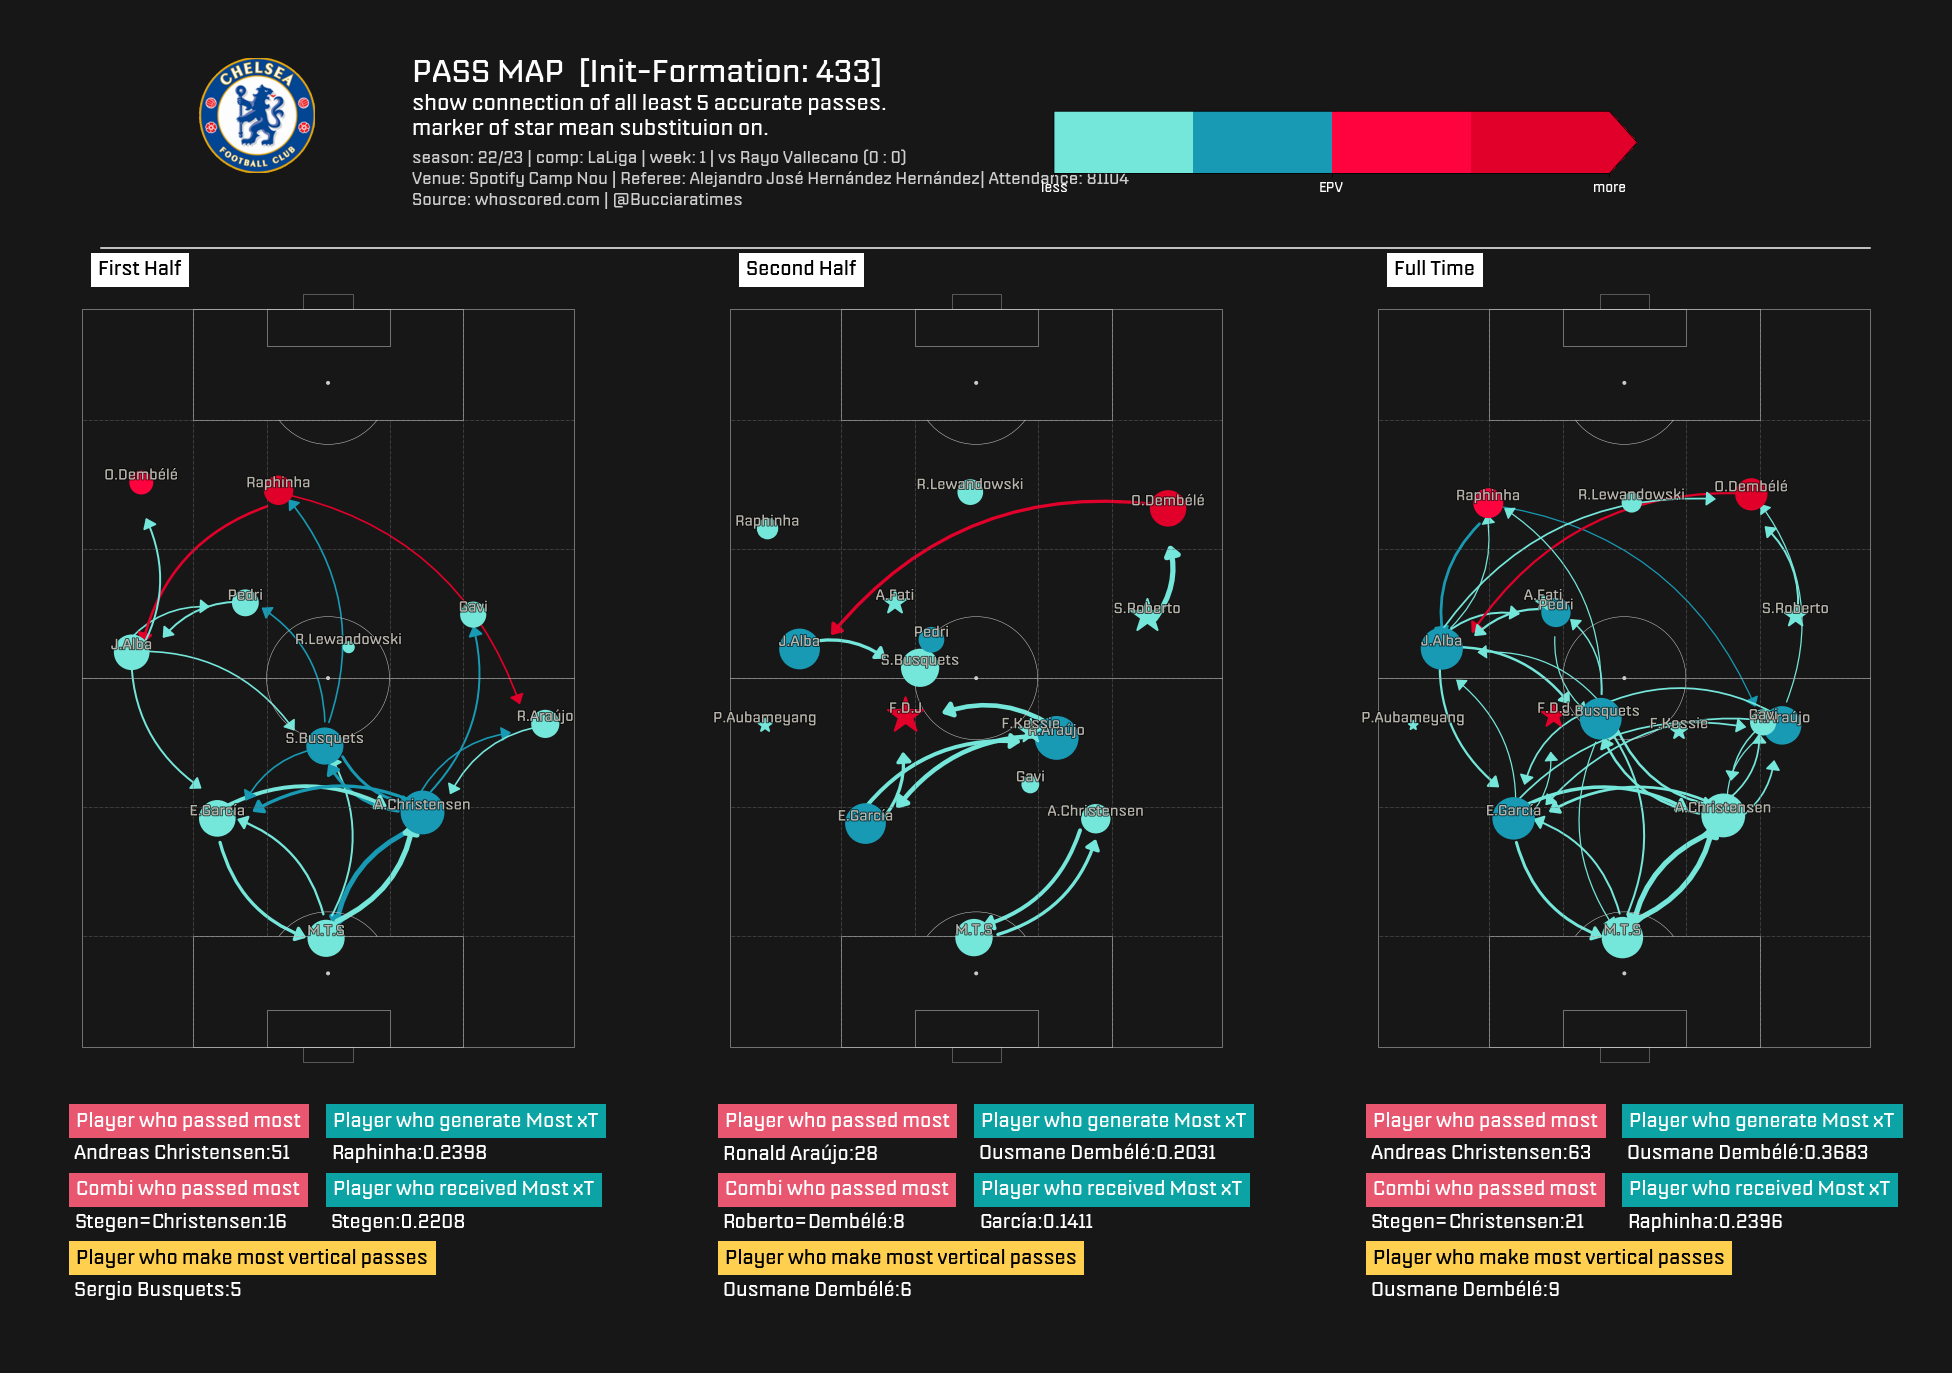

In [6]:
layout = [[0, 0, 1, 1, 2, 2],
          [0, 0, 1, 1, 2, 2],
          [0, 0, 1, 1, 2, 2],
          [3, 3, 4, 4, 5, 5],
          [3, 3, 4, 4, 5, 5]]

fig, axes = plt.subplot_mosaic(layout, linewidth=2,
                              constrained_layout=True,
                              figsize=(27, 16),
                              gridspec_kw={"width_ratios": [2, 2, 2, 2, 2, 2],
                                           "height_ratios": [2, 2, 2, 1, 1]})

fig_color = "#171717"
fig.set_facecolor(fig_color)

pitch = VerticalPitch(
    pitch_type='statsbomb',
    goal_type = 'box',
    pitch_color = fig_color,
    line_color = "#cdcdcd", 
    positional=True,
    positional_linestyle="-.",
    positional_color='#656565',
    figsize=(13.5,8),
    constrained_layout = True,
    tight_layout = True,
    line_zorder=1, linewidth=0.5,
    pad_top=15
)
for i in range(3):
    pitch.draw(ax=axes[i], tight_layout=True)
    #axes[i].invert_xaxis()

venue = "home"
for idx in range(3):

    pass_network = PassNetwork(
        ax=axes[idx], 
        team_name=team_name, 
        season=season, 
        week=week, 
        venue=venue)
    
    # data1 :passes_between
    # data2 :average_locs_and_count
    # data3 :average_locs_and_count_receipt
    data1, data2, data3 = pass_network.make_data(peri=idx)
    pass_network.plot_node(data2)
    pass_network.plot_network(data1)
    pass_network.plot_time(idx)
    pass_network.plot_note(axes[idx+3], data1, data2, data3)


fig_text(
    x=0.21, y=1.11, 
    s=f'PASS MAP  [Init-Formation: {pass_network.teamFormation}]',
    va='bottom', ha='left',
    fontsize=32, color='#fefefe', fontproperties=font_prop, fontweight='bold'
)
fig_text(
	x=0.21, y=1.065, 
    s='show connection of all least 5 accurate passes.\nmarker of star mean substituion on.',
	va='bottom', ha='left',
	fontsize=22, color='#fefefe', fontproperties=font_prop
)
fig_text(
	x=0.21, y=1.005, 
    s=f'season: {season[:2] + "/" + season[2:]} | comp: {pass_network.league} | week: {week} | vs {pass_network.opponent_name} ({pass_network.score})\
    \nVenue: {pass_network.venue_name} | Referee: {pass_network.referee}| Attendance: {pass_network.attendance}\nSource: whoscored.com | @Bucciaratimes',
	va='bottom', ha='left',
	fontsize=17, color='#cdcdcd', fontproperties=font_prop
)

fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
logo_ax = fig.add_axes(
    [.08, 1.035, .1, .1]
)
icon_id = 8455
club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{icon_id:.0f}.png')).convert('RGBA') # 白黒：LA
logo_ax.imshow(club_icon)
logo_ax.axis('off')

cax = plt.axes([0.54, 1.035, 0.3, 0.054])
color_bar = fig.colorbar(mappable=mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1, clip=False), cmap=cmapA),
                         cax=cax,
                         orientation='horizontal', 
                         extend='max',
                         anchor=(0.5,1.0), shrink=.6, ticks=[0, .5, 1])

color_bar.ax.set_xticklabels(["less", "EPV", "more"],fontdict={"color":"white","fontsize":14,"fontproperties":font_prop})

fig.add_artist(mpl.lines.Line2D([0.05, .96], [.97, .97], color="#f8f8f8"))
fig.add_artist(mpl.lines.Line2D([0.05, 0.05], [0, 1.18], color=fig_color, alpha=0))

# plt.savefig(f'/work/output/{team_name}-{week}-network.png', dpi=250, bbox_inches="tight", facecolor=axes[0].get_facecolor())

In [7]:
# datas[0][1].sort_values(by=["xT", "EPV"], ascending=False)
# datas[0][0].sort_values(by=["xT", "EPV"], ascending=False).columns
datas[0][2].sort_values(by=["xT_Receipt", "EPV_Receipt"], ascending=False)

NameError: name 'datas' is not defined

In [ ]:
!python /work/viz-template/passNet/PassNetwork.py

In [ ]:
ave[0]

location_formation = ave[0][['playerKitNumber', 'playerKitNumber_Receipt', 'x', 'y', "EPV", "xT"]].copy()

In [ ]:
location_formation.groupby(by=['playerKitNumber_Receipt']).agg(
            {'x':['mean','median'], 'y':['mean','median','count'], "EPV":["sum"], "xT":["sum"]})

In [ ]:
norm = plt.Normalize(data1["EPV"].min(), data1["EPV"].max())
for i in range(20):
    print(cmapA(norm(data1.loc[i,"xT"]))[0])
    
cmapA(norm(data1.loc[4,"xT"]))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

RdPu = plt.get_cmap('RdPu')

ax = plt.subplot(111)
ax.axis([-6,2,-4.5,3.2])
ax.set_aspect("equal")

X = np.linspace(0,1,17, endpoint=False)
Xt =np.sin(2.5*X+3)
Yt = 3*np.cos(2.6*X+3.4)

Xh = np.linspace(-0.5,-5,17)
Yh = -1.3*Xh-5

#Distance
D = data1["xT"]
norm = plt.Normalize(data1["xT"].min(), data1["xT"].max())

for xt, yt, xh, yh, d in zip(Xt,Yt,Xh,Yh,D):
    ax.annotate("Test", xy=(xh,yh), xycoords='data',
                xytext=(xt,yt), textcoords='data',
                size=10, arrowprops=dict(color=RdPu(norm(d))))

plt.show()